In [ ]:
install.packages("twitteR", repos = "https://cran.r-project.org/")
install.packages("ROAuth", repos = "https://cran.r-project.org/")
install.packages("ggmap", repos = "https://cran.r-project.org/")
install.packages("maps", repos = "https://cran.r-project.org/" )

1. Install the required packages:
 twitteR: To use Twitter API
 ROAuth: To connect with the Twitter API
 ggmap: To connect with the google API which will help to fetch the geocode of locations
 maps: To plot tweet locations on a map 

In [ ]:
SearchQuery <- '#sb51'

1. Query to be searched to fetch the tweets is stored in 'SearchQuery'. Currently set to the most trending hashtag of Super Bowl

In [1]:
library(twitteR)
library(ROAuth)
library(ggmap)
library(maps)

Loading required package: ggplot2


1. Import all the packages to access their functions

In [ ]:
consumer_key <- "BKro8XRNa8BqG7dl5kkfRNzAx"
consumer_secret <- "FAhRriPzc5jkEJX8LdzqDpDxzg1LDgXwwKU8nq8154RvAIpnQu"
access_token <- "772574727051370496-aM0inDDiZEow8fHaVBXHKV1uDiBtKeA"
access_secret <- "eIOajp1GUa0yR1sBXCIqEVHM7VJCo0c1dSGp6YoZHCm4J"
setup_twitter_oauth(consumer_key, consumer_secret, access_token, access_secret)

1. Use the generated keys from Twitter App to connect with Twitter API using OAuth

In [ ]:
retrievedTweetsBatch <- searchTwitter(SearchQuery, n=15000, geocode='38.0000,-96.1111,2000mi')
retrievedTweetsDF <- twListToDF(retrievedTweetsBatch)

1. Fetch 15000 tweets matching the search query with in USA [Co-ordinates 38.0000,-96.1111 mark the center of USA and 2000mi is approximate distance of the farthest point in USA from the center]
2. Store the tweets in a data frame to structure the data using twListToDF

In [ ]:
tweetUsers <- lookupUsers(retrievedTweetsDF$screenName)
tweetUsersDF <- unique(twListToDF(tweetUsers))
UserWithLocations <- tweetUsersDF[!(is.na(tweetUsersDF$location) | tweetUsersDF$location==""),]

1. Fetch the twitter user data for all the users of the tweets with help of function 'lookupUser' and the screennames of the users obtained from the retrieved tweet data
2. Store the user data in a structured format by converting it into a data frame using 'twListToDF'
3. Keep only the users who have linked their location to their twitter account

In [ ]:
Locations <- data.frame(location=NA)
Locations <- Locations[!(is.na(Locations$location)),]
Locations <- UserWithLocations$location
write.csv(Locations, "LocationsFile.csv", row.names=FALSE)

1. Create a data frame 'Locations' with just one column 'location' and no rows
2. Store the list of User locations in the empty data frame 'Locations'
3. Write the whole list of locations to a CSV file as maximum of 2500 locations can be processed at a time due to Google Maps API restriction.

In [ ]:
fetchedLocations <- read.csv("LocationsFile.csv", header = TRUE, sep = ",", stringsAsFactors=FALSE)

1. Fetch the locations from the stored CSV file.

In [ ]:
if(nrow(fetchedLocations) > 2000){
    fetchedLocationBatch <- fetchedLocations[1:2000,]
    write.csv(fetchedLocations[1001:nrow(fetchedLocations),], "Locations.csv", row.names=FALSE)
}else{
    fetchedLocationBatch <- fetchedLocations[1:nrow(fetchedLocations),]
    write.csv(data.frame(), "Locations.csv", row.names=FALSE)
}

1. Only fetch the first 2000 locations for processing to avoid QUERY_LIMIT_EXCEEDED exception and store it in 'fetchedLocationBatch'.
2. Remove the first 2000 locations from the file to avoid duplication of records. 
3. This command can be used multiple times to fetch all the locations from the stored file and process just 2000 at a time.

In [ ]:
if(file.exists("LocationCoordinates.csv")){
    LocationCoordinates <- read.csv("LocationCoordinates.csv", header = TRUE, sep = ",", stringsAsFactors=FALSE)  
}else{
    LocationCoordinates <- data.frame(lat=NA, lon=NA, freq=NA)
}
LocationCoordinates <- LocationCoordinates[!(is.na(LocationCoordinates$lat) | LocationCoordinates$lat==""),]

1. 'LocationCoordinate.csv' file is used to store the latitude and longitude co-ordinates for the list of processed locations.
2. 'LocationCoordinates' is used to store the value of already stored list of co-ordinates.
3. If there are no co-ordinates present then 'LocationCoordinates' is set to an empty data frame with 3 columns for latitude longitude and its occuring frequency

In [ ]:
getNewLocations <- geocode(fetchedLocationBatch)
getNewLocations$freq <- 1
getNewLocations <- getNewLocations[!(is.na(getNewLocations$lon) | getNewLocations$lon == ""),]
nrow(LocationCoordinates)
LocationCoordinates <- data.frame(rbind(LocationCoordinates,getNewLocations))
LocationCoordinates <- aggregate(freq~lon+lat,LocationCoordinates,sum)
nrow(LocationCoordinates)
write.csv(LocationCoordinates, "LocationCoordinates.csv", row.names=FALSE)

1. geocode function is used to fetch the co-ordinates of the new list of locations stored in 'fetchedLocationBatch' and the retrieved list of co-ordinates is assigned to data frame 'getNewLocations'.
2. Third column 'freq' is added and set to 1 for all the rows in the data frame 'getNewLocations'.
3. The old list of co-ordinates is combined with the newly retrieved list of co-ordinates i.e. data frame 'LocationCoordinates' is merged with 'getNewLocations' using rbind.
4. Frequency is calculated for individual pair of latitude and longitude using aggregate function.
5. The newly merged data set containing old and new co-ordinates with their corresponding frequency is stored in a CSV file.

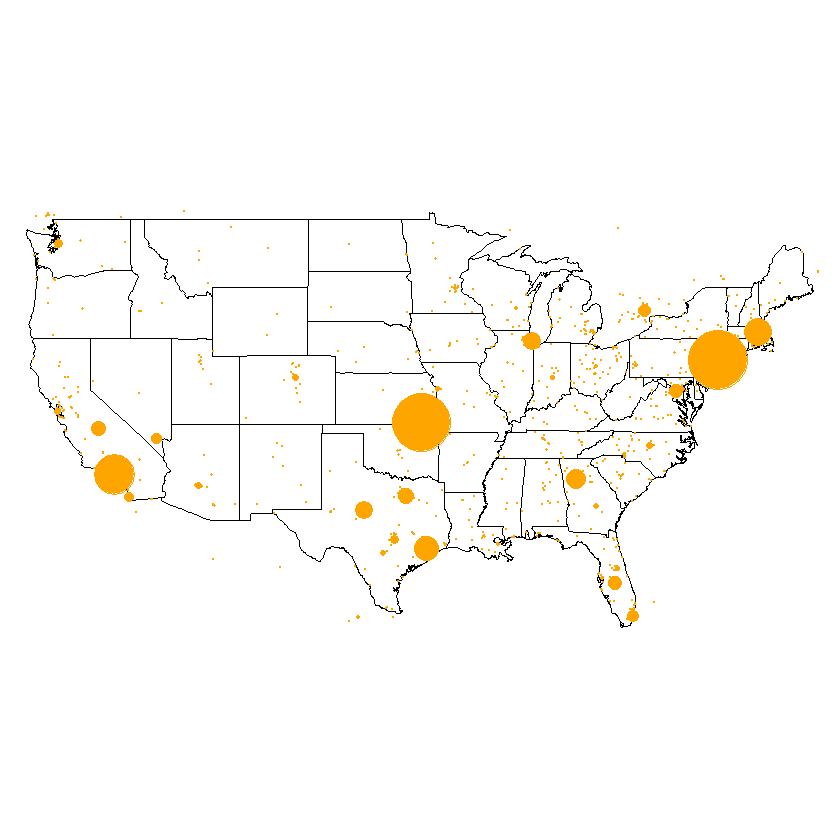

In [3]:
LocationCoordinates <- read.csv("LocationCoordinates.csv", header = TRUE, sep = ",", stringsAsFactors=FALSE)
sizeDivisor <- max(LocationCoordinates$freq)/10
map <- map(database="state", fill=TRUE, col="white", bg="white", mar=c(0,0,0,0))
points(LocationCoordinates$lon,LocationCoordinates$lat, pch=20, grp=LocationCoordinates$count, col="orange", cex=LocationCoordinates$freq/sizeDivisor)

1. Fetch the list of co-ordinates and their frequency in a the data frame 'LocationCoordinates'
2. Size of the points on the map is based on the frequency of the latitude longitude pair. The size has been normalized in the range of 0-10.9 so that the point does not appear too large or too small on the map, if there is a huge difference between max and min frequency.
3. 'sizeDivisor' is used to divide the frequency and set the size of point depending on the calculated value. 
4. To plot the map the 'map' function from 'maps' package is used.
5. A map of USA is plotted using the database of 'state'.
6. Co-ordinates are plotted on the map using the 'points' function. Size is set to the value of frequency divided by 'sizeDivisor'.
** Current File contains 6297 Locations and total points are identified using the frequency of the latitude longitude pair **

References:
1. https://cran.r-project.org/web/packages/twitteR/twitteR.pdf
2. https://cran.r-project.org/web/packages/ggmap/ggmap.pdf
3. https://www.youtube.com/watch?v=zmiC7X9fUmo&t=331s
4. https://cran.r-project.org/web/packages/maps/maps.pdf
5. https://stat.ethz.ch/R-manual/R-patched/library/graphics/html/points.html